# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from scipy import sparse
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from scipy.sparse import coo_matrix, hstack


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
review_length=[]
for sent in final['Text'].values:
    
    review_length.append(len(sent))
   

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []

In [24]:

# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:20<00:00, 1137.53it/s]


In [25]:
import pickle
with open("preprocessed_reviews.txt", "wb") as fp:   #Pickling
    pickle.dump(preprocessed_reviews, fp)

In [26]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [27]:

#https://www.kaggle.com/premvardhan/amazon-fine-food-review-tsne-visualization/notebook

final['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 


In [28]:
Sample_data=final.sample(n = 100000)

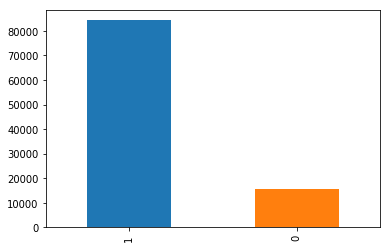

In [29]:
Sample_data["Score"].value_counts().plot(kind='bar')

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [30]:
## Similartly you can do preprocessing for review summary also.

In [31]:
#Function to Split the data into Test and Train 
def Split_data(X,Y):
    # intermediate/test split (gives us test set)
    from sklearn.model_selection import train_test_split
    train_x, test_x, train_y, test_y = train_test_split(X, Y, shuffle=True,test_size=0.30)
    print('train: {}% |  test {}%'.format(round(len(train_y)/len(Y),2),
                                                       round(len(test_y)/len(Y),2)))
    return train_x,train_y,test_x,test_y

In [32]:
#Instializing the input data and Output varibles 
X = Sample_data["CleanedText"]
y = Sample_data["Score"]
print(X.shape, y.shape)

(100000,) (100000,)


In [33]:
#Split the data into test and train 
X_train,y_train,x_test,y_test = Split_data(X,y)

train: 0.7% |  test 0.3%


In [34]:
#Split the data into test and CV
X_tr, y_tr, X_cv, y_cv =Split_data(X_train,y_train)

train: 0.7% |  test 0.3%


# [4] Featurization

In [35]:
#function to add a new feature lenght of each review 
def Add_new_feature(data,Feature):
    #array to capture the length of each review
    review_length=[]
    #Loop runs through the data and captures the length of each review
    for sent in data.values:
        review_length.append(len(sent))
    #As this is a List we convert to matrix to append the feature with the BOW/tfidf features which will be in matrix 
    review_length=sparse.csr_matrix(review_length)
    #Transpose will help to convert all row s to colums to fit the resultent matrix to the feature matrix
    review_length=sparse.csr_matrix.transpose(review_length)
    print("the type of new feature ",type(review_length))
    print("the shape of new feature ",review_length.get_shape())
    #Append the new feature to the existing feature matrix this function will output an arry so we convert it to orginal matrix form again
    Feature_new = hstack([review_length,Feature])
    Feature_new =sparse.csr_matrix(Feature_new)
    print("the type of new count vectorizer ",type(Feature_new))
    print("the shape of out text new BOW vectorizer ",Feature_new.get_shape())
    print("the number of unique words ", Feature_new.get_shape()[1])
    return Feature_new
    

## [4.1] BAG OF WORDS

In [36]:
from sklearn import preprocessing
#BoW for train data
count_vect = CountVectorizer() #in scikit-learn
BOW_train = count_vect.fit_transform(X_tr)
#Normalize Data
BOW_train = preprocessing.normalize(BOW_train)
print("the type of count vectorizer ",type(BOW_train))
print("the shape of out text BOW vectorizer ",BOW_train.get_shape())
print("the number of unique words ", BOW_train.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 42908)
the number of unique words  42908


In [37]:
#Adding new feature to the train BOW feature matrix
BOW_train_new=Add_new_feature(X_tr,BOW_train)

the type of new feature  <class 'scipy.sparse.csc.csc_matrix'>
the shape of new feature  (49000, 1)
the type of new count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text new BOW vectorizer  (49000, 42909)
the number of unique words  42909


In [38]:
#BoW for test data
BOW_c_test = count_vect.transform(X_cv)
#Normalize Data
BOW_c_test = preprocessing.normalize(BOW_c_test)
print("the type of count vectorizer ",type(BOW_c_test))
print("the shape of out text BOW vectorizer ",BOW_c_test.get_shape())
print("the number of unique words ", BOW_c_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 42908)
the number of unique words  42908


In [39]:
#Adding new feature to the CV BOW feature matrix
BOW_c_test_new=Add_new_feature(X_cv,BOW_c_test)

the type of new feature  <class 'scipy.sparse.csc.csc_matrix'>
the shape of new feature  (21000, 1)
the type of new count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text new BOW vectorizer  (21000, 42909)
the number of unique words  42909


In [40]:
#BoW for test data
BOW_test = count_vect.transform(x_test)
#Normalize Data
BOW_test = preprocessing.normalize(BOW_test)
print("the type of count vectorizer ",type(BOW_test))
print("the shape of out text BOW vectorizer ",BOW_test.get_shape())
print("the number of unique words ", BOW_test.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 42908)
the number of unique words  42908


In [41]:
#Adding new feature to the test BOW feature matrix
BOW_test_new=Add_new_feature(x_test,BOW_test)

the type of new feature  <class 'scipy.sparse.csc.csc_matrix'>
the shape of new feature  (30000, 1)
the type of new count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text new BOW vectorizer  (30000, 42909)
the number of unique words  42909


## [4.2] TF-IDF

In [42]:
#Instilize the function to calculate the TF-IDF 
tf_idf_vect= TfidfVectorizer(ngram_range=(1,2), min_df=10)

Train_tf_idf = tf_idf_vect.fit_transform(X_tr)
#Normalize the data
Train_tf_idf = preprocessing.normalize(Train_tf_idf)
print("the type of count vectorizer ",type(Train_tf_idf))
print("the shape of out text TFIDF vectorizer ",Train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", Train_tf_idf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49000, 28649)
the number of unique words including both unigrams and bigrams  28649


In [43]:
#Adding new feature to the test tfidffeature matrix
Train_tf_idf_new=Add_new_feature(X_tr,Train_tf_idf)

the type of new feature  <class 'scipy.sparse.csc.csc_matrix'>
the shape of new feature  (49000, 1)
the type of new count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text new BOW vectorizer  (49000, 28650)
the number of unique words  28650


In [44]:
Train_c_tf_idf = tf_idf_vect.transform(X_cv)
Train_c_tf_idf = preprocessing.normalize(Train_c_tf_idf)
print("the type of count vectorizer ",type(Train_c_tf_idf))
print("the shape of out text TFIDF vectorizer ",Train_c_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", Train_c_tf_idf.get_shape()[1])

#minimizing the the features 


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (21000, 28649)
the number of unique words including both unigrams and bigrams  28649


In [45]:
#Adding new feature to the test tfidf feature matrix
Train_c_tf_idf_new=Add_new_feature(X_cv,Train_c_tf_idf)

the type of new feature  <class 'scipy.sparse.csc.csc_matrix'>
the shape of new feature  (21000, 1)
the type of new count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text new BOW vectorizer  (21000, 28650)
the number of unique words  28650


In [46]:
Test_tf_idf = tf_idf_vect.transform(x_test)
Test_tf_idf = preprocessing.normalize(Test_tf_idf)
print("the type of count vectorizer ",type(Test_tf_idf))
print("the shape of out text TFIDF vectorizer ",Test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", Test_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30000, 28649)
the number of unique words including both unigrams and bigrams  28649


In [47]:
#Adding new feature to the test tfidf feature matrix
Test_tf_idf_new=Add_new_feature(x_test,Test_tf_idf)

the type of new feature  <class 'scipy.sparse.csc.csc_matrix'>
the shape of new feature  (30000, 1)
the type of new count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text new BOW vectorizer  (30000, 28650)
the number of unique words  28650


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [48]:
#Save the processed tfidf w2v to local for future referance


In [49]:
#function to perform the Hyper-Perameter Tunning
def Hyper_PM_tunning(KDX_train,KDY_train):
    #GridSearchCV
    param_grid = {'alpha':neighbors}
    MNavie=MultinomialNB(class_prior = [0.5, 0.5])
    MNavie_CV= GridSearchCV(MNavie,param_grid,cv=10,verbose=1,scoring='roc_auc')
    MNavie_CV.fit(KDX_train,KDY_train)
    #save the file to local for future referance
    with open("MNavie_CV.txt", "wb") as fp:   #Pickling
        pickle.dump(MNavie_CV, fp)
    print("Best HyperParameter: ",MNavie_CV.best_params_)
    print("Best Accuracy: %.2f%%"%(MNavie_CV.best_score_*100))

In [50]:
#Function to Plot the AUC values for each alpha 

def Plot_AUC(Train_auc,cv_auc):
    #plt AUC for Test and the Validation 
    plt.title('AUC Varying for different Alpha')
    plt.plot(neighbors, Train_auc, label='Testing AUC')
    plt.plot(neighbors, cv_auc, label='Validation AUC')
    High_test_AUC = neighbors[Train_auc.index(max(Train_auc))]
    print('\nThe highest AUC for test data is for  alpha  %.3f.' % High_test_AUC)
    High_CV_AUC  = neighbors[cv_auc.index(max(cv_auc))]
    print('\nThe highest AUC for CV data is for  alpha %.3f.' % High_CV_AUC)
    plt.legend()
    plt.xlabel('Alpha values ')
    plt.ylabel('AUC Values')
    plt.show()

In [51]:
# Function to find the optimal Alpha value
def find_OPT_K(KDX_train,KDY_train,KDX_test,KDY_test):
    
    Train_auc= []
    cv_auc= []
    cv_scores = []
    for i,k in enumerate(neighbors):
        #Setup a MultinomialNB classifier with k alpha value
        model = MultinomialNB(alpha = k,class_prior = [0.5, 0.5])
    
    
        #Fit the model
        model.fit(KDX_train, KDY_train)
    
      
        
        #Acu values for the Train data
        probs_train = model.predict_proba(KDX_train)
        preds_train = probs_train[:,1]
        fpr_train, tpr_train, threshold_train = metrics.roc_curve(KDY_train, preds_train)
        Train_auc.append(metrics.auc(fpr_train, tpr_train)*100)
        
        #Acu values for the Test data
        probs = model.predict_proba(KDX_test)
        preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(KDY_test, preds)
      
        cv_auc.append(metrics.auc(fpr, tpr)*100)
        
        # perform simple  cross validation on train 
        scores = cross_val_score(model, KDX_train, KDY_train, cv=10, scoring='roc_auc')
        cv_scores.append(scores.mean())
    
    optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
    print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
    Plot_AUC(Train_auc,cv_auc)
    return optimal_alpha


In [52]:
#function to plot the ROC curve for train and the Test Data 
def plot_roc(KDX_train,KDY_train,X_test,Y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(KDX_train)
    preds = probs[:,1]
    fpr_train, tpr_train, threshold = metrics.roc_curve(KDY_train, preds)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)*float(100)
    probs_test = model.predict_proba(X_test)
    preds_test = probs_test[:,1]
    fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test, preds_test)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)*float(100)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_train, tpr_train, label = 'Train AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc_train,roc_auc_test

In [53]:
#Function to print the Confusion matrix

def Confusion_Matrix(X_test,Y_test):

    pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, pred)
    class_label = ["positive","negative"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [54]:
#Function to Print the top n feature 
def important_features(vectorizer,classifier,n,labele):

    if(labele == "negative"):
        i=0
    elif(labele == "positive"):
        i=1
    else:
        print("provide negative/positive lable %s is nt valied" %labele)
    class_labels = classifier.classes_

    feature_names =vectorizer.get_feature_names()

    topn_class = sorted(zip(classifier.feature_count_[i], feature_names),reverse=True)[:n]

    print("Important words in %s reviews" %labele)

    for coef, feat in topn_class:

        print(class_labels[i], coef, feat)

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [55]:
# Please write all the code with proper documentation

In [56]:
MX_train=BOW_train
MX_test=BOW_c_test
MY_train=y_tr
MY_test=y_cv

In [57]:
#taking a wide range of alpha values from 10^-5 to 10^5
neighbors = []
i =  0.000001
while(i<=100000):
    neighbors.append(np.round(i,8))
    i *= 3

bnb = MultinomialNB(class_prior = [0.5, 0.5])

In [58]:
print(neighbors)

[1e-06, 3e-06, 9e-06, 2.7e-05, 8.1e-05, 0.000243, 0.000729, 0.002187, 0.006561, 0.019683, 0.059049, 0.177147, 0.531441, 1.594323, 4.782969, 14.348907, 43.046721, 129.140163, 387.420489, 1162.261467, 3486.784401, 10460.353203, 31381.059609, 94143.178827]



The optimal value of alpha is 0.059.

The highest AUC for test data is for  alpha  0.000.

The highest AUC for CV data is for  alpha 0.059.


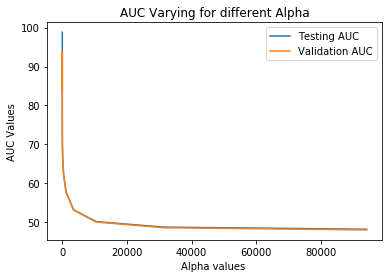

In [59]:
#find the optimal alpha for the MultinomialNB
optimal_alpha=find_OPT_K(MX_train,MY_train,MX_test,MY_test)

In [60]:
#Fit the model with optimal alpha value 
model = MultinomialNB(alpha =0.059,class_prior = [0.5, 0.5])
#Fit the model
model.fit(MX_train, MY_train)

MultinomialNB(alpha=0.059, class_prior=[0.5, 0.5], fit_prior=True)

In [61]:
print("Training Score for optimal alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for optimal alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for optimal alpha is : ",model.score(BOW_test, y_test)*100)

Training Score for optimal alpha is :  91.71020408163265
CV Score for optimal alpha is :  88.92380952380952
Test Score for optimal alpha is :  88.86666666666667


In [62]:
#Hyperperameter Tuning for Best  alpha for the MultinomialNB
Best_alpha=Hyper_PM_tunning(MX_train,MY_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   35.8s finished


Best HyperParameter:  {'alpha': 0.059049}
Best Accuracy: 93.21%


In [63]:
#Fit the model with Best alpha value 
model = MultinomialNB(alpha =0.059,class_prior = [0.5, 0.5])
#Fit the model
model.fit(MX_train, MY_train)

MultinomialNB(alpha=0.059, class_prior=[0.5, 0.5], fit_prior=True)

In [64]:
print("Training Score for Best alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for Best alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for Best alpha is : ",model.score(BOW_test, y_test)*100)

Training Score for Best alpha is :  91.71020408163265
CV Score for Best alpha is :  88.92380952380952
Test Score for Best alpha is :  88.86666666666667


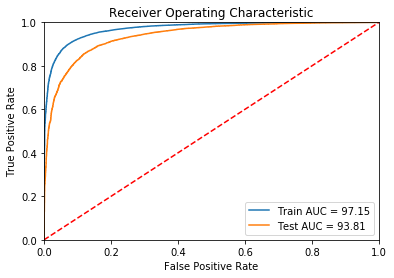

In [65]:
#Print the ROC curve for the test and training data 
BOW_Train_AUC,BOW_Test_AUC=plot_roc(MX_train,MY_train,BOW_test,y_test)

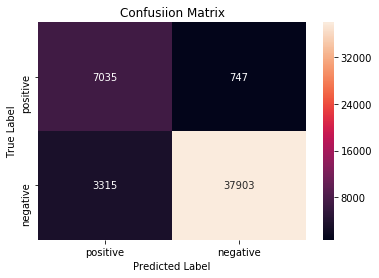

In [66]:
#Confusion Matrix for Train Data
Confusion_Matrix(MX_train,MY_train)

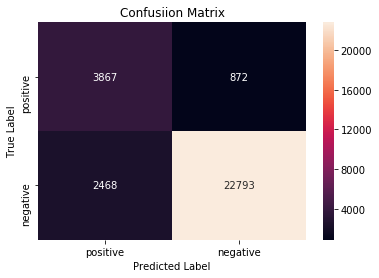

In [67]:
#Confusion Matrix for Test Data
Confusion_Matrix(BOW_test,y_test)

In [68]:
BOW_Model=model

### Adding a New Feature review length and verifing the Model Perfomance 

In [69]:
#Load the data with new feature Data set
MX_train=BOW_train_new
MX_test=BOW_c_test_new
MY_train=y_tr
MY_test=y_cv


The optimal value of alpha is 0.059.

The highest AUC for test data is for  alpha  0.000.

The highest AUC for CV data is for  alpha 0.059.


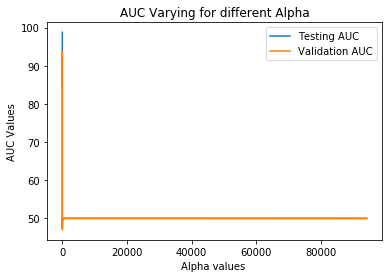

In [70]:
#find the optimal alpha for the MultinomialNB
optimal_alpha=find_OPT_K(MX_train,MY_train,MX_test,MY_test)

In [71]:
model = MultinomialNB(alpha =0.059,class_prior = [0.5, 0.5])
#Fit the model
model.fit(MX_train, MY_train)

MultinomialNB(alpha=0.059, class_prior=[0.5, 0.5], fit_prior=True)

In [72]:
print("Training Score for optimal alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for optimal alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for optimal alpha is : ",model.score(BOW_test_new, y_test)*100)

Training Score for optimal alpha is :  91.31428571428572
CV Score for optimal alpha is :  88.61904761904762
Test Score for optimal alpha is :  88.57333333333334


In [73]:
#find the Best alpha for the MultinomialNB with hyperperameter tunning
Best_alpha=Hyper_PM_tunning(MX_train,MY_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   40.7s finished


Best HyperParameter:  {'alpha': 0.059049}
Best Accuracy: 93.07%


In [74]:
model = MultinomialNB(alpha =0.059,class_prior = [0.5, 0.5])
#Fit the model
model.fit(MX_train, MY_train)

MultinomialNB(alpha=0.059, class_prior=[0.5, 0.5], fit_prior=True)

In [75]:
print("Training Score for Best alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for Best alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for Best alpha is : ",model.score(BOW_test_new, y_test)*100)


Training Score for Best alpha is :  91.31428571428572
CV Score for Best alpha is :  88.61904761904762
Test Score for Best alpha is :  88.57333333333334


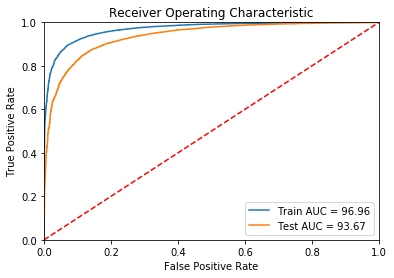

In [76]:
BOW_Train_AUC_New,BOW_Test_AUC_New=plot_roc(MX_train,MY_train,BOW_test_new,y_test)

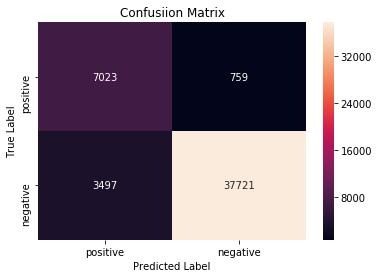

In [77]:
#Confusion Matrix with train dataset
Confusion_Matrix(MX_train,MY_train)

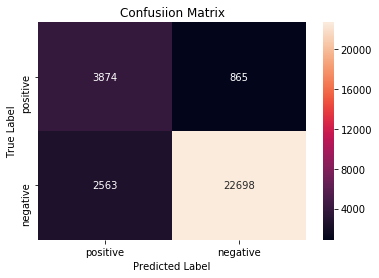

In [78]:
#Confusion Matrix with test dataset
Confusion_Matrix(BOW_test_new,y_test)

In [79]:
BOW_Model_new=model

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [80]:
#Top 10 Features of Postive class 
important_features(count_vect,BOW_Model,10,"positive")

Important words in positive reviews
0 4877.220857518181 not
0 2350.634632086267 great
0 2245.116704588181 good
0 2137.9861703224615 like
0 1638.7762719747554 love
0 1581.344034607647 product
0 1526.9644016539257 taste
0 1515.0835620480182 one
0 1383.8645861786995 coffee
0 1382.840575117228 flavor


In [81]:
#Top 10 Features of Postive class with new feature 
important_features(count_vect,BOW_Model_new,10,"positive")

Important words in positive reviews
0 10342115.0 aa
0 4877.220857518181 notable
0 2350.634632086267 greatcoffee
0 2245.116704588181 goodbar
0 2137.9861703224615 likeability
0 1638.7762719747554 loveable
0 1581.344034607647 productand
0 1526.9644016539257 tasteand
0 1515.0835620480182 oneat
0 1383.8645861786995 coffeeam


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [82]:
#Top 10 Features of Negative class 
important_features(count_vect,BOW_Model,10,"negative")

Important words in negative reviews
0 1644.6864047936936 not
0 534.9987145943688 like
0 427.74105041239886 product
0 416.1793337763289 taste
0 396.8854561440918 would
0 308.99635525191076 one
0 263.4653964321093 good
0 243.56273371938167 no
0 237.99169227804433 flavor
0 236.23632888092828 coffee


In [83]:
#Top 10 Features of Negative class with new feature
important_features(count_vect,BOW_Model_new,10,"negative")

Important words in negative reviews
0 2178484.0 aa
0 1644.6864047936936 notable
0 534.9987145943688 likeability
0 427.74105041239886 productand
0 416.1793337763289 tasteand
0 396.8854561440918 woulda
0 308.99635525191076 oneat
0 263.4653964321093 goodbar
0 243.56273371938167 noah
0 237.99169227804433 flavorable


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [84]:
MX_train=Train_tf_idf
MX_test=Train_c_tf_idf
MY_train=y_tr
MY_test=y_cv


The optimal value of alpha is 0.177.

The highest AUC for test data is for  alpha  0.000.

The highest AUC for CV data is for  alpha 0.177.


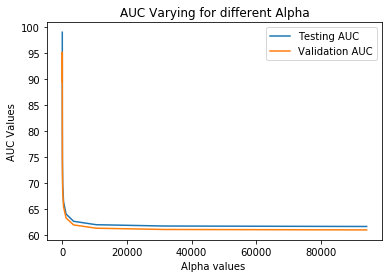

In [85]:
#find the Optimal alpha for the MultinomialNB 
optimal_alpha=find_OPT_K(MX_train,MY_train,MX_test,MY_test)

In [86]:
        model = MultinomialNB(alpha =0.177,class_prior = [0.5, 0.5])
    #Fit the model
        model.fit(MX_train, MY_train)

MultinomialNB(alpha=0.177, class_prior=[0.5, 0.5], fit_prior=True)

In [87]:
print("Training Score for Best alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for Best alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for Best alpha is : ",model.score(Test_tf_idf, y_test)*100)

Training Score for Best alpha is :  91.82857142857142
CV Score for Best alpha is :  89.0
Test Score for Best alpha is :  89.07333333333334


In [88]:
#find the Best alpha for the MultinomialNB with hyperperameter tunning
Best_alpha=Hyper_PM_tunning(MX_train,MY_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   46.4s finished


Best HyperParameter:  {'alpha': 0.177147}
Best Accuracy: 95.33%


In [89]:
        model = MultinomialNB(alpha =0.117,class_prior = [0.5, 0.5])
    #Fit the model
        model.fit(MX_train, MY_train)

MultinomialNB(alpha=0.117, class_prior=[0.5, 0.5], fit_prior=True)

In [90]:
print("Training Score for Best alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for Best alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for Best alpha is : ",model.score(Test_tf_idf, y_test)*100)

Training Score for Best alpha is :  92.22857142857143
CV Score for Best alpha is :  89.16666666666667
Test Score for Best alpha is :  89.21


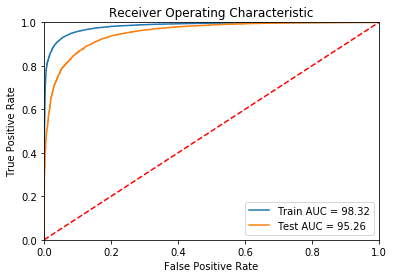

In [91]:
#Plot the ROC curve for test and Train data 
tfidf_Train_AUC,tfidf_Test_AUC = plot_roc(MX_train,MY_train,Test_tf_idf,y_test)

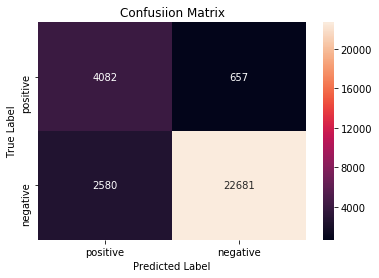

In [92]:
#Confusion Matrix for Test data
Confusion_Matrix(Test_tf_idf,y_test)

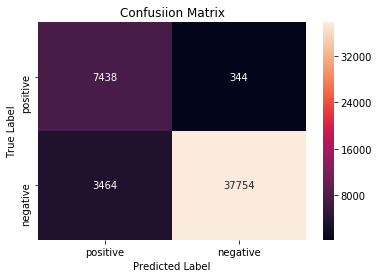

In [93]:
#Confusion Matrix for Train data
Confusion_Matrix(MX_train,MY_train)

In [94]:
tf_idf_Model=model

### Adding a New Feature review length and verifing the Model Perfomance 

In [95]:
MX_train=Train_tf_idf_new
MX_test=Train_c_tf_idf_new
MY_train=y_tr
MY_test=y_cv


The optimal value of alpha is 0.177.

The highest AUC for test data is for  alpha  0.000.

The highest AUC for CV data is for  alpha 0.177.


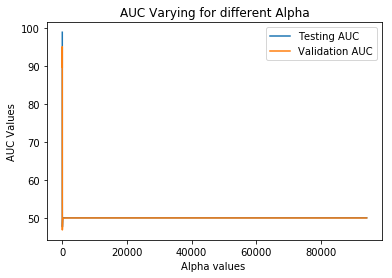

In [96]:
#find the Optimal alpha for the MultinomialNB 
optimal_alpha=find_OPT_K(MX_train,MY_train,MX_test,MY_test)

In [97]:
model = MultinomialNB(alpha =0.117,class_prior = [0.5, 0.5])
#Fit the model
model.fit(MX_train, MY_train)

MultinomialNB(alpha=0.117, class_prior=[0.5, 0.5], fit_prior=True)

In [98]:
print("Training Score for Best alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for Best alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for Best alpha is : ",model.score(Test_tf_idf_new, y_test)*100)

Training Score for Best alpha is :  92.03673469387755
CV Score for Best alpha is :  88.96190476190476
Test Score for Best alpha is :  88.97


In [99]:
#find the Best alpha for the MultinomialNB with hyperperameter tunning
Best_alpha=Hyper_PM_tunning(MX_train,MY_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   36.1s finished


Best HyperParameter:  {'alpha': 0.177147}
Best Accuracy: 95.33%


In [100]:
model = MultinomialNB(alpha =0.117,class_prior = [0.5, 0.5])
#Fit the model
model.fit(MX_train, MY_train)


MultinomialNB(alpha=0.117, class_prior=[0.5, 0.5], fit_prior=True)

In [101]:
print("Training Score for Best alpha is : ",model.score(MX_train, MY_train)*100)
print("CV Score for Best alpha is : ",model.score(MX_test, MY_test)*100)
print("Test Score for Best alpha is : ",model.score(Test_tf_idf_new, y_test)*100)

Training Score for Best alpha is :  92.03673469387755
CV Score for Best alpha is :  88.96190476190476
Test Score for Best alpha is :  88.97


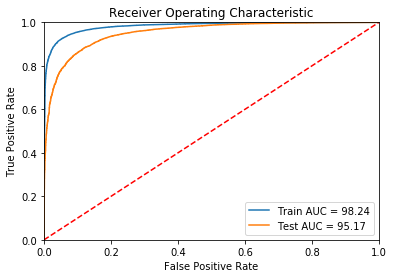

In [102]:
#Plot the ROC curve for test and the train data 
tfidf_Train_AUC_new,tfidf_Test_AUC_new=plot_roc(MX_train,MY_train,Test_tf_idf_new,y_test)


Confusion Matrix for Train Data


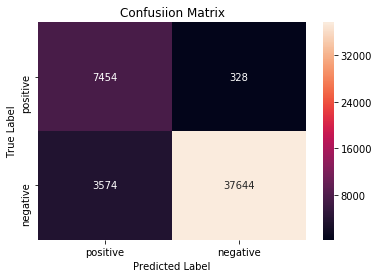

Confusion Matrix for Test Data


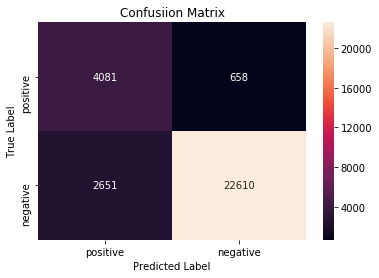

In [103]:

#Confusion Matrix for Test and Train data
print("Confusion Matrix for Train Data")
Confusion_Matrix(MX_train,MY_train)
print("Confusion Matrix for Test Data")
Confusion_Matrix(Test_tf_idf_new,y_test)


In [104]:
tf_idf_Model_new =model


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [105]:
#Top 10 Features of Postive classs
Tfidf_Pov_fev=important_features(tf_idf_vect,tf_idf_Model,10,"positive")

Important words in positive reviews
0 1235.3601512638593 not
0 871.7634134184359 great
0 810.3322447248672 good
0 750.9682361021412 like
0 696.4994954445472 coffee
0 694.0356582020069 tea
0 680.0286691808969 love
0 634.6918317395368 product
0 603.7866933303004 taste
0 598.1258113221047 one


In [106]:
#Top 10 Features of Postive class with new feature 
Tfidf_Pov_fev_new=important_features(tf_idf_vect,tf_idf_Model_new,10,"positive")

Important words in positive reviews
0 10342115.0 abandoned
0 1235.3601512638593 not able
0 871.7634134184359 great able
0 810.3322447248672 good able
0 750.9682361021412 like able
0 696.4994954445472 coffee absolutely
0 694.0356582020069 tea absolutely
0 680.0286691808969 love able
0 634.6918317395368 product absolutely
0 603.7866933303004 taste absolutely


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [107]:
#Top 10 Features of negative class 
Tfidf_Neg_fev=important_features(tf_idf_vect,tf_idf_Model,10,"negative")

Important words in negative reviews
0 427.07570799368864 not
0 192.957018668071 like
0 176.97312153321428 product
0 169.47376545346276 taste
0 165.8387591682988 would
0 124.91777540907407 one
0 122.22660263482877 coffee
0 113.86113719434596 no
0 102.80322544381264 flavor
0 97.63164137236411 good


In [108]:
#Top 10 Features of negative class with new feature 
Tfidf_Neg_fev_new=important_features(tf_idf_vect,tf_idf_Model_new,10,"negative")

Important words in negative reviews
0 2178484.0 abandoned
0 427.07570799368864 not able
0 192.957018668071 like able
0 176.97312153321428 product absolutely
0 169.47376545346276 taste absolutely
0 165.8387591682988 would able
0 124.91777540907407 one absolutely
0 122.22660263482877 coffee absolutely
0 113.86113719434596 no added
0 102.80322544381264 flavor absolutely


# [6] Conclusions

In [109]:
# Please compare all your models using Prettytable library

In [110]:
Best_Alpha_BOW=0.059
Best_Alpha_BOW_New=0.059
Best_Alpha_tfidf=0.177
Best_Alpha_tfidf_new=0.177

In [111]:
from prettytable import PrettyTable

names = ["Navie Bayes for BoW", "Navie Bayes for BoW with New Feature","Navie Bayes for tfidf", "Navie Bayes for tfidf with New Feature"]

optimal_Alpha = [Best_Alpha_BOW,Best_Alpha_BOW_New,Best_Alpha_tfidf,Best_Alpha_tfidf_new]

train_acc = [BOW_Train_AUC,BOW_Train_AUC_New,tfidf_Train_AUC,tfidf_Train_AUC_new]

test_acc = [BOW_Test_AUC,BOW_Test_AUC_New,tfidf_Test_AUC,tfidf_Test_AUC_new]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_Alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+----------------------------------------+------------+-------------------+-------------------+
| S.NO. |                 MODEL                  | Best Alpha | Training Accuracy |   Test Accuracy   |
+-------+----------------------------------------+------------+-------------------+-------------------+
|   1   |          Navie Bayes for BoW           |   0.059    | 97.15398837971783 | 93.81178579612805 |
|   2   |  Navie Bayes for BoW with New Feature  |   0.059    | 96.95786199582767 | 93.67195422602965 |
|   3   |         Navie Bayes for tfidf          |   0.177    |  98.3182481824736 |  95.2560685310102 |
|   4   | Navie Bayes for tfidf with New Feature |   0.177    |  98.2360118521077 | 95.16943928346492 |
+-------+----------------------------------------+------------+-------------------+-------------------+


Conclusions

    Best Accuracy of 95.37% is achieved by Navie Bayes for tfidf Featurization
    The Navie Bayes with New feature gives relatively similar results  
    Best alpha value is simmilar after adding new feature 
   